In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

# Load the data
CDFS = pd.read_csv('../DATA/ZFOURGE/CDFS/CDFS_MAIN7.csv')
COSMOS = pd.read_csv('../DATA/ZFOURGE/COSMOS/COSMOS_MAIN7.csv')
UDS = pd.read_csv('../DATA/ZFOURGE/UDS/UDS_MAIN7.csv')
df = pd.concat([CDFS, COSMOS, UDS], ignore_index=True)
df = df[(df['Use'] == 1) & (df['LIR'] > 0)]

# PACS 160um good/bad
good_160 = df[df['160_good'] == 1]
bad_160 = df[df['160_good'] == 0]

# redshift bins
redshift_bins = [(0.00, 0.30), (0.30, 0.45), (0.45, 0.60), 
                 (0.60, 0.80), (0.80, 1.00), (1.00, 1.20),
                 (1.20, 1.70), (1.70, 2.00), (2.00, 2.50),
                 (2.50, 3.00), (3.00, 4.20), (4.20, 6.00)] 

# T-Test

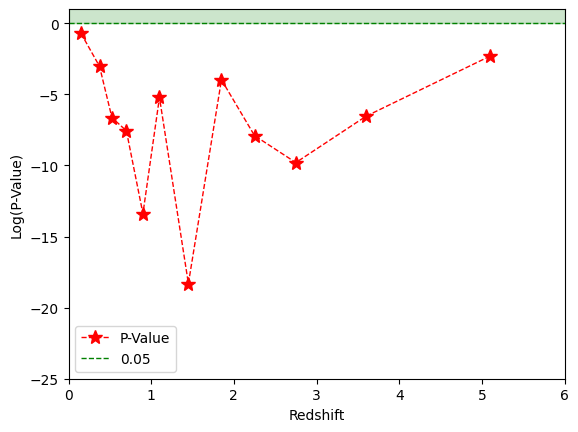

In [2]:
ttest_results = []

for z_start, z_end in redshift_bins:
    P_values = []
    for i in range(1000):
        mask_good = (good_160['zpk'] >= z_start) & (good_160['zpk'] < z_end)
        mask_bad = (bad_160['zpk'] >= z_start) & (bad_160['zpk'] < z_end)

        good_lum = np.log10(good_160[mask_good]['LIR'].values)
        bad_lum = np.log10((bad_160[mask_bad]['LIR']).sample(n=len(good_lum)).values)
            
        _, p_value = stats.ttest_ind(good_lum, bad_lum)
        P_values.append(p_value)
    
    median_p_value = np.median(P_values)
    ttest_results.append(median_p_value)
        
# Plot the p-values across redshift bins
z_mean = np.mean(redshift_bins, axis=1)
plt.plot(z_mean, np.log10(ttest_results), color='red', marker='*', markersize=10, linestyle='--', linewidth=1, label='P-Value')
plt.plot([0,6], [0.05, 0.05], color='green', linestyle='--', linewidth=1, label='0.05')
plt.fill_between([0,6], 0.05, 10, color='green', alpha=0.2)
plt.xlim(0, 6)
plt.ylim(-25, 1)
plt.xlabel('Redshift')
plt.ylabel('Log(P-Value)')
plt.legend()
plt.show()

# Luminosity Error

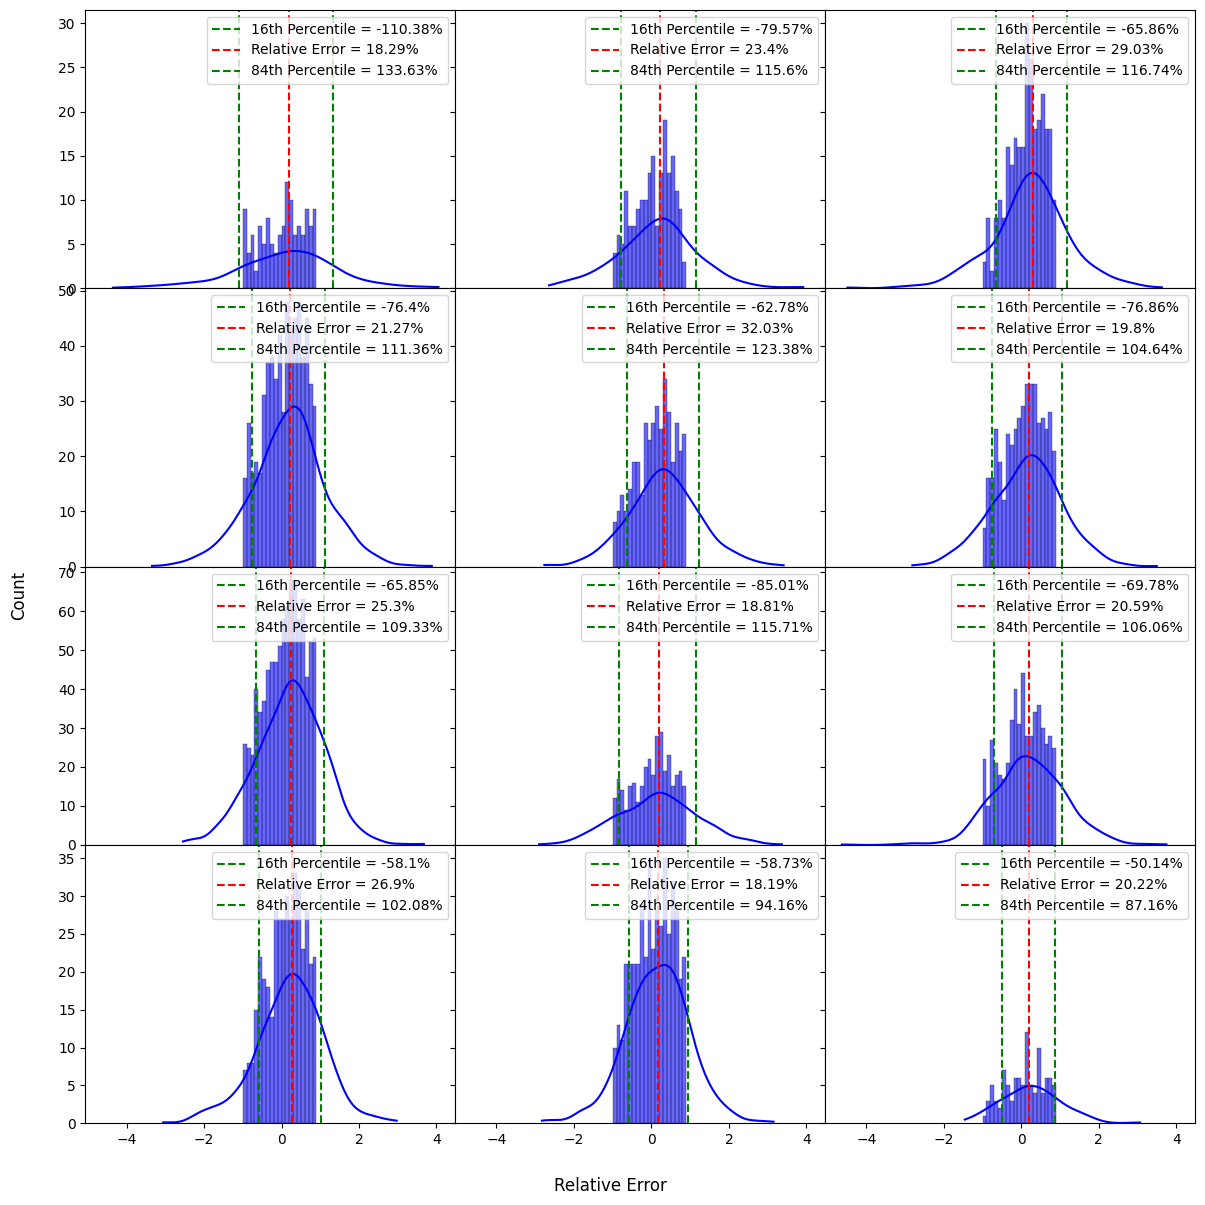

In [3]:
fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharex=True, sharey='row')
axes = axes.flatten()

for (z_start, z_end), ax in zip(redshift_bins, axes):
    all_delta_L = []
    for i in range(1000):
        
        mask_good = (good_160['zpk'] >= z_start) & (good_160['zpk'] < z_end)
        mask_bad = (bad_160['zpk'] >= z_start) & (bad_160['zpk'] < z_end)

        good_lum = np.log10(good_160[mask_good]['LIR'].values)
        bad_lum = np.log10((bad_160[mask_bad]['LIR']).sample(n=len(good_lum)).values)
    
        Delta_L = bad_lum - good_lum
        all_delta_L.extend(Delta_L)
        
    median = np.median(all_delta_L)
    perc_16 = np.percentile(all_delta_L, 16)
    perc_84 = np.percentile(all_delta_L, 84)
    
    sns.histplot(Delta_L, ax=ax, kde=True, color="blue", alpha=0.6, bins=np.arange(-1, 1, 0.1)).set(ylabel=None)
    ax.axvline(perc_16, color='green', linestyle='--', label=f'16th Percentile = {np.round(perc_16*100, 2)}%')
    ax.axvline(median, color='red', linestyle='--', label=f'Relative Error = {np.round(median*100, 2)}%')
    ax.axvline(perc_84, color='green', linestyle='--', label=f'84th Percentile = {np.round(perc_84*100, 2)}%')
    ax.legend(loc='upper right')

fig.supylabel('Count', x=0, fontsize=12)
fig.supxlabel('Relative Error', y=0, fontsize=12)
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('lir_hist_relative.png')
plt.show()